# FinnSentiment

Neural Network implementation of sentiment analysis using **FinnSentiment** dataset from https://github.com/cynarr/sentiment-analysis/tree/master/data-raw

## 1.1 data preprocessing

In [25]:
#import essential packages for the project
import numpy as np
import matplotlib.pyplot as plt

from string import punctuation

import nltk
from nltk.tokenize import word_tokenize

import tensorflow as tf

%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
# function to read data from a file
def process_data(datatype, language, label):
    '''
        input:
            - datatype: 'train' or 'test'
            - language: 'en'(English) or 'fi'(Finnish)
            - label: 'pos'(positive) or 'neg'(negative)
        output:
            - list of sentences
    '''
    filename = label + '_test.txt' if datatype=='test' else label + '.txt'
    filepath = 'data-raw/bin/' + language + '/' + datatype + '/' + filename

    with open(filepath, mode='r', encoding='utf8') as f:
        sentences = f.readlines()

    # -------------------------------------------------- data preprocessing  -------------------------------------------------- #
    processed = []
    
    for sentence in sentences:
        sentence = sentence.lower() # lowercase
        sentence = sentence.replace('\n','') # remove \n  

        words = word_tokenize(sentence) # tokenisation
        # remove non-alphabet characters and punctuations
        for word in words:
            if (word in list(punctuation)) or word.isalpha()==False: 
                words.remove(word)
                
        # append list of words of a sentence to data
        processed.append(words)
    # -------------------------------------------------- data preprocessing  -------------------------------------------------- #

    pol = 1 if label == 'pos' else 0 #polarity
    processed = [(sentence, pol) for sentence in processed]
    return processed

In [27]:
# data preprocessing: get list of words for each sentence
train_pos = process_data('train','fi','pos')
train_neg = process_data('train','fi','neg')
test_pos = process_data('test','fi','pos')
test_neg = process_data('test','fi','neg')

print('preprocessing successful!')

preprocessing successful!


In [28]:
train = train_pos + train_neg
test = test_pos + test_neg

In [29]:
import random

seed = 1
random.seed(seed)

random.shuffle(train)
random.shuffle(test)

In [30]:
input_train, label_train = [e[0] for e in train], [e[1] for e in train]
input_test, label_test = [e[0] for e in test], [e[1] for e in test]

In [31]:
corpus = set([word for e in input_train for word in e])
vocab_size = len(corpus)
print('there are %d unique words in the corpus' %(vocab_size))

there are 9066 unique words in the corpus


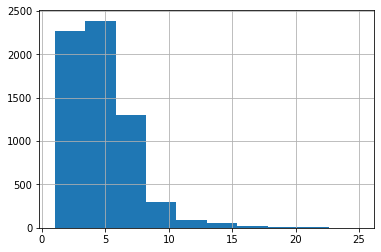

count    6427.000000
mean        4.680878
std         2.456990
min         1.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        25.000000
dtype: float64

In [32]:
import pandas as pd

length = [len(e) for e in input_train + input_test]
maxlen = max(length)
seq_len = maxlen

pd.Series(length).hist()
plt.show()
pd.Series(length).describe()

In [33]:
# pad / add unknown
pad = '<PAD>'
unk = '<UNK>'

input_train_mod = list()
for sentence in input_train:
    sentence_padded = sentence
    for j in range(seq_len):
        if j >= len(sentence):
            sentence_padded.append(pad)
    input_train_mod.append(sentence_padded)

input_test_mod= list()
for sentence in input_test:
    s = []
    for j in range(seq_len):
        if j >= len(sentence):
            s.append(pad)
        else:  
            word = sentence[j]
            if word not in corpus:
                s.append(unk)
            else:
                s.append(word)
    input_test_mod.append(s)

In [34]:
len(input_train), len(input_train[1]) 

(5774, 25)

In [35]:
input_train = input_train_mod
input_test = input_test_mod

In [36]:
encoder = {w:i+2 for i,w in enumerate(corpus)}

pad_val = 0
unk_val = 1
encoder[pad] = pad_val
encoder[unk] = unk_val

In [37]:
# encode
ipt_tr = []
for sentence in input_train:
    s = []
    for word in sentence:
        s.append(encoder[word])
    ipt_tr.append(s) 

ipt_t = []
for sentence in input_test:
    s = []
    for word in sentence:
        s.append(encoder[word])
    ipt_t.append(s) 

In [38]:
# train
ipt_tr = ipt_tr
lab_tr = label_train

# test
ipt_t = ipt_t
lab_t = label_test

## 1.2 build model

In [62]:
from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras import Sequential

In [53]:
no_layers = 2
vocab_size = len(corpus) + 2 # <PAD> and <UNK>
embedding_dim = 64
output_dim = 1
hidden_dim = 256
dropout = 0.5

model = Sequential() 
model.add(Input(shape=(seq_len,)))
model.add(Embedding(vocab_size, embedding_dim, input_length=seq_len)) 
model.add(LSTM(embedding_dim)) # lstm from keras


model.add(Dropout(dropout)) 
model.add(Dense(output_dim, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 25, 64)            580352    
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 613441 (2.34 MB)
Trainable params: 613441 (2.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 1.3 train and validate

In [54]:
num_epochs = 10
batch_size = 50

model.fit(ipt_tr, lab_tr, validation_data=(ipt_t, lab_t), epochs=num_epochs, batch_size=batch_size)

Epoch 1/10
116/116 [==============================] - 3s 15ms/step - loss: 0.6886 - accuracy: 0.4446 - val_loss: 0.6866 - val_accuracy: 0.4456
Epoch 2/10
116/116 [==============================] - 1s 11ms/step - loss: 0.5275 - accuracy: 0.4446 - val_loss: 0.5714 - val_accuracy: 0.4456
Epoch 3/10
116/116 [==============================] - 1s 12ms/step - loss: 0.2649 - accuracy: 0.4446 - val_loss: 0.6725 - val_accuracy: 0.4456
Epoch 4/10
116/116 [==============================] - 1s 12ms/step - loss: 0.1361 - accuracy: 0.4446 - val_loss: 0.8010 - val_accuracy: 0.4456
Epoch 5/10
116/116 [==============================] - 1s 11ms/step - loss: 0.0804 - accuracy: 0.4446 - val_loss: 0.8842 - val_accuracy: 0.4456
Epoch 6/10
116/116 [==============================] - 1s 11ms/step - loss: 0.0627 - accuracy: 0.4446 - val_loss: 1.2182 - val_accuracy: 0.4456
Epoch 7/10
116/116 [==============================] - 1s 11ms/step - loss: 0.0426 - accuracy: 0.4446 - val_loss: 1.2585 - val_accuracy: 0.4456

## 1.4. model evaluation visulisation

In [55]:
model_eval = model.evaluate(ipt_t, lab_t)

21/21 [==============================] - 0s 4ms/step - loss: 1.7338 - accuracy: 0.4456


In [56]:
model.save('lstm-finnsentiment-keras.h5')

## 1.5 testing and prediction

In [57]:
from keras.utils import pad_sequences

In [59]:
# for user prediction
def user_input_processing(review):
    to_predict = []

    review_text = review

    # preprocess the review
    to_predict = []
    for word in review.split(" "):
        word = str.lower(word)
        if word[-1] == ".":
            word = word[:-1]
        if word not in corpus:
            word = unk
        to_predict.append(encoder[word])
    to_predict = pad_sequences([to_predict], seq_len, padding='post')

    # pol = 'positive' if model.predict(np.array(to_predict))[0] > 0.5 else 'negative'
    
    print(review_text, model.predict(np.array(to_predict))[0])

In [60]:
texts = [
    'Saat yhdeksän yhdestä paketista, koska olen hyvällä tuulella.', # You get nine out of one pack because I'm in a good mood
    'täydellinen ruoka', # 'perfect food' 
    'Yksi viime vuosien hienoimmista elokuvista', # 'One of the finest films made in recent years.' 
    'Ennustettavaa ja huonoa. Näyttelijätyö oli kauheaa ja tarina yhteinen', # 'Predictable and bad. The acting was terrible and the story was common.'
    'huonot palvelut', # 'bad services' 
    'Olet niin kaunis.' # 'you are so beautiful' 
]

for text in texts:
    user_input_processing(text)

1/1 [==============================] - 0s 317ms/step
Saat yhdeksän yhdestä paketista, koska olen hyvällä tuulella. [1.]
1/1 [==============================] - 0s 31ms/step
täydellinen ruoka [1.]
1/1 [==============================] - 0s 13ms/step
Yksi viime vuosien hienoimmista elokuvista [1.]
1/1 [==============================] - 0s 64ms/step
Ennustettavaa ja huonoa. Näyttelijätyö oli kauheaa ja tarina yhteinen [1.]
1/1 [==============================] - 0s 19ms/step
huonot palvelut [1.]
1/1 [==============================] - 0s 16ms/step
Olet niin kaunis. [1.]
